# 基于MindSpore Quantum的Shor算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindquantum/zh_cn/case_library/mindspore_shor_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindquantum/zh_cn/case_library/mindspore_shor_algorithm.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindquantum/docs/source_zh_cn/case_library/shor_algorithm.ipynb)

## Shor算法简介

Shor算法在量子计算机上分解整数$N$的时间复杂度为$logN$，几乎是对已知最有效的经典因数分解算法的$e$指数级加速，这种加速有可能在量子计算机上中断如RSA的现代加密机制。

## Shor算法基本思路

Shor算法要解决的主要问题是：给定一个整数$N$，找出它的质因数。即对一个给定的较大数$N$在多项式时间内确定两个素因子 $p1$和$p2$满足$p1\cdot p2=N$。 在介绍Shor算法步骤之前，先介绍一些数论知识。

因子分解涉及到数论里的一些知识，可以将因子分解问题归结为函数

$$
f(x)=a^x\ mod\ N
$$

对于$a$的周期查找（$a$和$N$互质，否则通过调用$gcd(a,N)$就可以马上得到一个因子）。 由于函数$f(x)$存在周期$r$满足$f(x)=f(x+r)$。在这种情形下，就可得

$$
a^x=a^{x+r}\ mod\ N\ \ \forall x
$$

令$x=0$，得到$a^r=1+qN$，其中$q$为某一整数，即

$$
a^r-1=(a^{r/2}-1)(a^{r/2}+1)=qN
$$

这也表明对于$N$使用$gcd$就可以找到其因子。

因此，Shor算法的核心在于，将大数分解的问题转化为找周期的问题。由于量子计算可以利用叠加态进行并行计算，因此通过量子算法我们可以很快地找到函数$f(x)$的周期$r$（具体的原理和步骤请参考本文档中的`周期查找算法`）。总的来说，我们需要在量子线路中实现$f(|x\rangle)=a^{|x\rangle}\ mod\ N$的函数运算，可以构造一个酉矩阵$U_{a,N}$使得$U_{a,N}|x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x) \rangle$，然后利用量子傅立叶变换我们就可以找到周期$r$满足$a^r\equiv 1(\ mod\ N)$。

下面以 $N=15$为例，介绍Shor算法在因子分解的步骤：

1. 选择一个任意的数字，比如$a=2(<15)$

2. 求最大公约数，$gcd(a,N)=gcd(2,15)=1$

3. 找函数$f(x)=a^x\ mod\ N$的周期，使得$f(x+r)=f(x)$

4. 通过量子电路图运算得到$r=4$

5. 求最大公约数，$\gcd(a^{r/2}+1,N)=\gcd(5,15)=5$

6. 求最大公约数，$\gcd(a^{r/2}-1,N)=\gcd(3,15)=3$

7. $N=15$分解得到的质数结果为3和5，分解完成。

Shor算法的量子电路如下图所示：

![shor's algorithm circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindquantum/docs/source_zh_cn/images/shor_algorithm_circuit.png)

## 通过MindSpore Quantum实现Shor算法

首先，导入需要用到的模块。

In [1]:
#pylint: disable=W0611
import numpy as np
from fractions import Fraction
import mindquantum as mq
from mindquantum.core.gates import X, Z, H, UnivMathGate, Measure
from mindquantum.core.circuit import Circuit, controlled, UN
from mindquantum.algorithm.library import qft
from mindquantum.simulator import Simulator

从Shor算法的基本思路我们可以看出，Shor算法最核心的部分就在于由量子计算机处理的周期查找算法，而周期查找算法中最困难的地方就是将态$|x\rangle |y\rangle$变为$|x\rangle |y \oplus f(x) \rangle$的算子$U$，这个算子的量子线路构造较为复杂，因此以下我们先通过经典计算机算出算子$U$并当作一个Oracle，以便本文档可以整体而直观地演示出Shor算法。

### 构造Oracle

该Oracle的构造方法原本十分简单，只需3步：

1. 将变换前所有可能的$x$进行穷举（从$0$到$N-1$共有$N$个数），并一一算出对应的$f(x)=a^x\ mod\ N$。
2. 对每一个$x$，我们都可以写出变换前的态$|x\rangle |0\rangle$和变换后的态$|x\rangle |f(x)\rangle$的矩阵表示，将它们进行外乘即可得到每一个$x$对应的变换矩阵，然后将所有矩阵求和即得到算子$U$的矩阵表示，即

    $$
    U=\sum_{x=0}^{N-1} |x\rangle |0\rangle \langle x|\langle f(x)|
    $$

3. 用矩阵$U$生成自定义门。

举例：$N=15,a=2$的情况，我们可以得到$x$与$f(x)$:

In [2]:
q = 4  # 比特数
N = 15
a = 2
x = []
f = []
for i in range(2**q):
    x.append(i)
    f.append(a**i % N)
print('x: ', x)
print('f(x): ', f)

x:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f(x):  [1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8]


然后计算$|0\rangle |0\rangle \langle 0| \langle 1|+|1\rangle |0\rangle \langle 1| \langle 2|+|2\rangle |0\rangle \langle 2|\langle 4|+...$即得到变换$U$的矩阵表示。其中$|0\rangle |0\rangle$、$|0\rangle |1\rangle$、$|0\rangle |2\rangle$...可以表示为相互正交的、含有256个元素的列向量，其中只有一个元素是1，其余为0。例如$|0\rangle |0\rangle$是第一个元素是1，$|0\rangle |1\rangle$是第二个元素是1，$|1\rangle |0\rangle$是第17个元素为1，以此类推。

但是，由于MindSpore Quantum当前版本的Simulator对自定义门的比特数做出了限制（不能大于5比特），而即使分解最小的非偶质因数整数15=3*5也要至少8个比特，因此构造此Oracle使用了妥协而复杂得多的办法，即寄存器1（4个比特）作为控制比特，在寄存器2（4个比特）作用每一个$x$对应的变换$T_x$：

$$
T_x|x\rangle \rightarrow |a^x\ mod\ N\rangle
$$

每一个$T_x$都受寄存器1控制，只当寄存器1中存储的数为$x$时才作用，最后一共有$N$个门，包括这$N$个门的整个线路对应于算子$U$。需要注意的是，$T_x$自身不是一个门，因为它不是一个可逆操作，因此仅当寄存器2处于$|0\rangle$态时，该Oracle才能给出正确的输出。

下面是妥协后的Oracle构造方法：

In [3]:
def U_operator(N, a, register1, register2):
    Q = 2**len(register1)
    x = []
    f = []
    for i in range(Q):
        x.append(i)
        f.append(a**i % N)  # 计算f(x)

    # 创建量子态|register2>的矩阵表示
    vector = np.zeros((Q, Q))
    for i in range(Q):
        vector[i, i] = 1

    T = []
    for i in range(Q):
        matrix = np.outer(vector[f[i]], vector[0])  # 计算映射Tx的矩阵
        T.append(UnivMathGate(f'f({i})', matrix))  # 用变换矩阵构造Tx“门”

    # 创建控制线路，得到算子U。对于每个Tx“门”，都受寄存器1中所有比特控制，其对应x的二进制中比特位是1的是正常控制节点，比特位是0的则要在控制节点两侧作用X门，翻转控制位
    circuit = Circuit()
    for i in range(Q):
        bin_x = bin(x[i])[2:]  # 将x转换为二进制
        flip_control_qubit = list(range(len(register1)))  # 初始化需要作用X门的比特的list

        for j in range(len(bin_x)):
            if bin_x[len(bin_x) - j - 1] == '1':  # 获得x的二进制中是‘1’的比特
                flip_control_qubit.remove(j)  # 从list中删除不需要作用X门的控制比特

        circuit.barrier()  # 添加barrier
        circuit += UN(X, flip_control_qubit)  # 在控制节点前作用X门
        circuit += T[x[i]].on(register2, list(register1))  # 给Tx“门”接上控制比特
        circuit += UN(X, flip_control_qubit)  # 在控制节点后作用X门

    return circuit

现在，`U_operator()`函数就可以对寄存器1中的量子态$|x\rangle$进行指数模运算，并将得到的结果$a^{|x\rangle}\ mod\ N$存入寄存器2。

举例：$N=15,a=2$的情况，我们构造出对应的$U$算子，并验证它是否能正确得到结果（寄存器1和寄存器2各需要4个比特来存储$x$和$f(x)$）：

1¦00010100⟩


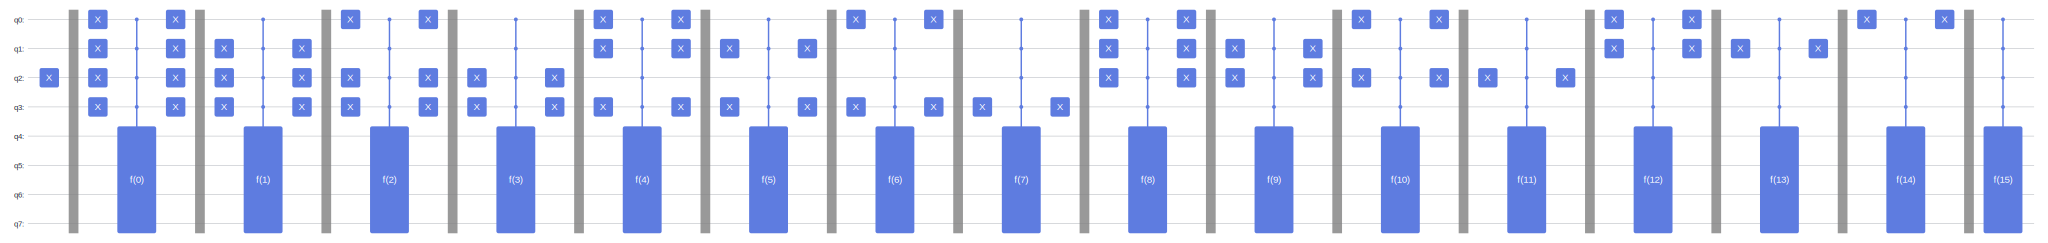

In [4]:
# pylint: disable=W0104
register1 = range(4)
register2 = range(4, 8)
circuit = Circuit(X.on(2))  # 创建线路，使输入态为|0100⟩|0000⟩，即x=8，|8⟩|0⟩
circuit += U_operator(15, 2, register1, register2)  # 作用U算子

print(circuit.get_qs('mqvector', ket=True))  # 打印末态
circuit.svg() #打印线路

寄存器1中结果为0100，寄存器2中结果为0001，先前我们已经算出了$f(8)=2^8\ mod\ 15=1$，因此输出结果正确。线路虽然看起来较为复杂，实际上就是16个受控4比特门依次作用而已，前四个比特上的 [X](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.10/core/gates/mindquantum.core.gates.XGate.html) 门用途为翻转控制位。

接下来我们需要实现周期查找算法。

### 周期查找算法

1. 在寄存器1中我们需要$q>log_2 N$个比特来记录自变量$x \in [0,N-1]$的二进制数，寄存器2中同样需要$q$个比特来记录$f(x)=a^x\ mod\ N\ \in [0,N-1]$的二进制数。此时寄存器1和寄存器2分别能记录$[0,Q-1]$的整数,其中$Q=2^q>N$。
2. 对寄存器1中的所有比特作用 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.10/core/gates/mindquantum.core.gates.HGate.html) 门，此时寄存器1中的比特处于$[0,Q-1]$中所有整数的均匀叠加态

    $$
    |\psi\rangle=\sum_{x=0}^{Q-1}|x\rangle
    $$

3. 对寄存器1存储的态$|\psi\rangle$做函数运算$a^{|\psi\rangle}\ mod\ N$，并将结果存入寄存器2，此步骤由先前构造的U_operator完成。由于直接对叠加态$|\psi\rangle$进行运算，此步骤只需一步完成，体现了量子计算的优势————并行计算。此时线路中存储的态是纠缠态，可以表示为

    $$
    \sum_{x=0}^{Q-1}|x\rangle|f(x)\rangle=\sum_{i=0}^{r-1}(|i\rangle+|i+r\rangle+|i+2r\rangle+...)\ |f(i)\rangle
    $$

4. 对寄存器1做傅立叶逆变换，此变换使用一个$Q$次单位根$\omega^{2\pi i/Q}$，会将任意给定态$|x\rangle$的振幅平均分布在$Q$个$|y\rangle$态上。而如步骤3中显示的，寄存器1中$|i\rangle$与$|i+r\rangle$等态均与寄存器2中同一个态$|f(i)\rangle$相纠缠，因此会发生量子干涉，最终使得当单位矢量$\omega^{2\pi iry/Q}$越接近1（指向正实数轴）时，测量得到态$|y\rangle$的概率越大。换句话说，我们测得的态$|y\rangle$，有很大概率使得$\frac{ry}{Q}$接近某一整数$c$。更详尽的数学描述可以参考链接：<https://zh.wikipedia.org/wiki/秀爾演算法> 中的“量子部分：周期查找子程序”。
5. 测量寄存器1，得到二进制串。将二进制数转化为十进制数$y$，此时$\frac{y}{Q}\sim\frac{c}{r}$，其中$c$是未知整数。通过连分数分解法计算$\frac{y}{Q}$逼近的不可约分数（分母不大于$N$），取其分母即得到周期$r$。但是，在分母小于$N$的不可约分数中可能存在比$\frac{c}{r}$更逼近$\frac{y}{Q}$的分数，或是$c$与$r$存在公因数，则得到的$r$会是真正函数周期的因数，此时计算失败，重新计算。

举例：还是用$N=15,a=2$的例子，在`构造Oracle`中我们把每一个$f(x)$都算了出来，从中可以直接看出函数周期为4。现在我们可以搭建对应的周期查找线路，并进行100次模拟，看看会得到哪些结果。

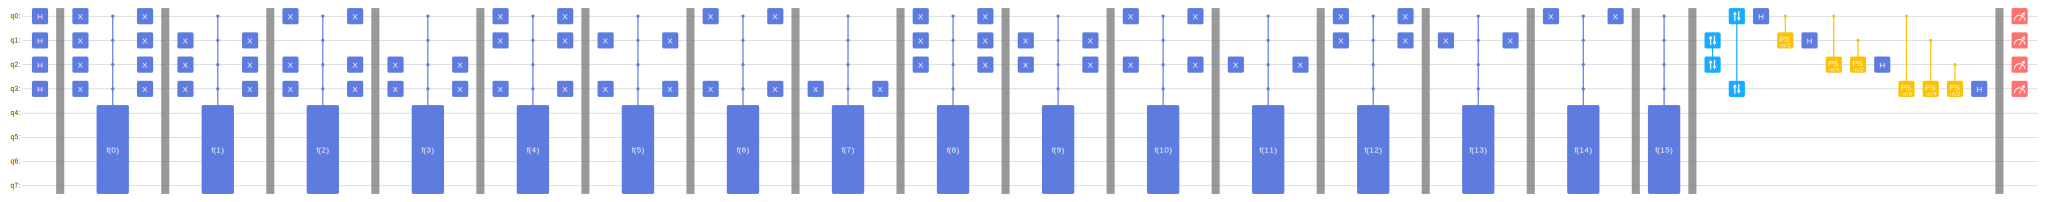

In [5]:
# pylint: disable=W0104
circuit = Circuit()  # 创建量子线路
register1 = range(4)  # 设置前4个比特为寄存器1
register2 = range(4, 8)  # 设置后4个比特为寄存器2

circuit += UN(H, register1)  # 对寄存器1中的所有比特作用H门

# 对寄存器1做模乘运算，并将结果存入寄存器2，该操作由一个大的U门完成
circuit += U_operator(15, 2, register1, register2)

circuit.barrier()  # 添加barrier
circuit += qft(register1[::-1]).hermitian()  # 对寄存器1做傅立叶逆变换，须注意傅立叶变换作用的比特顺序，在这里需要反序
circuit.barrier()  # 添加barrier
circuit += UN(Measure(), register1)  # 测量寄存器1

circuit.svg()  # 画出线路图

从线路图我们可以很直观地看到，整个周期查找线路由四部分组成：产生叠加态$\rightarrow$函数运算$\rightarrow$傅立叶逆变换$\rightarrow$测量。

接下来运行该线路100次，观察测量结果。

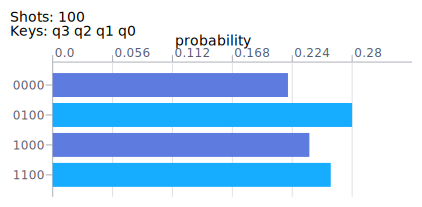

In [6]:
# pylint: disable=W0104
sim = Simulator('mqvector', circuit.n_qubits)  # 创建量子线路模拟器

# 模拟线路100次，打印测量结果，随机种子seed设为100内的随机整数
result = sim.sampling(circuit, shots=100, seed=np.random.randint(100))

result.svg()

从统计结果可以看出，最后寄存器1中只可能测出4个态，分别是$y=[0,4,8,12]$，这是由于$\omega^{2\pi iry/Q}\ (Q=16)$当$y$取这四个值时恰好为1，而其他的态由于量子干涉导致概率幅抵消为零。把测量结果代入$\frac{y}{Q}\sim\frac{c}{r}$，可以看出该式确实成立，我们有约50%的概率得到正确的周期$r$，但有约25%概率得到$r$的因数，还有25%概率得到0态，后两种情况需要重新计算。

接下来构造的是通用的周期查找算法。

In [7]:
def period_finder(N, a, q):
    circuit = Circuit()  # 创建量子线路
    register1 = range(q)  # 设置前q个比特为寄存器1
    register2 = range(q, 2 * q)  # 设置后q个比特为寄存器2

    circuit += UN(H, register1)  # 对寄存器1中的所有比特作用H门

    # 对寄存器1做模乘运算，并将结果存入寄存器2，该操作由一个大的U门完成
    circuit += U_operator(N, a, register1, register2)

    circuit += qft(register1[::-1]).hermitian()  # 对寄存器1做傅立叶逆变换，须注意傅立叶变换作用的比特顺序，在这里需要反序
    circuit.barrier()  # 添加barrier
    circuit += UN(Measure(), register1)  # 测量寄存器1

    sim = Simulator('mqvector', circuit.n_qubits)  # 创建量子线路模拟器

    # 模拟线路，收集测量结果，随机种子seed设为100内的随机整数
    result = sim.sampling(circuit, seed=np.random.randint(100))

    # result.data是一个字典，key是测量结果，value是出现频数，我们只做了一次采样，因此只有一个key, value必定为1
    result = list(result.data.keys())[0]  # 将key取出
    result = int(result, 2)  # 将结果从二进制转化为十进制

    # 通过连分数分解法计算result/2**q逼近的不可约分数，分母不能大于N
    eigenphase = float(result / 2**q)
    f = Fraction.from_float(eigenphase).limit_denominator(N)
    r = f.denominator  # 取f的分母，得到周期r

    # r有可能是周期的因数，因此需要验证，当且仅当r是函数周期本身时返回r，否则返回None
    if a**r % N == 1:
        return r
    return None

### 经典计算机部分

经典计算机部分负责将因数分解问题转化成寻找函数周期的问题，具体步骤如下：

1. 随机取一个小于$N$的整数$a$，用gcd算法验证$a$与$N$是否互质，若$a$与$N$存在公因数，则直接得到$N$的一个因数，输出结果。

2. 计算需要$q$个比特来存储$N$的二进制数。

3. 用周期查找算法得到函数$f(x)=a^x\ mod\ N$的周期$r$。

4. 判断$r$是否为偶数，若不是则回到第一步。

5. 计算$a^{r/2}+1$和$a^{r/2}-1$，它们当中必有其一与$N$存在非1公因数。但是，$a^{r/2}+1$有可能可以整除$N$，因此最后输出结果仍有可能是$N$本身。

In [8]:
#pylint: disable=C0121,R1705
def shor(N):
    while True:
        a = np.random.randint(N - 2) + 2  # 获得区间[2,N-1]内的随机整数a
        b = np.gcd(a, N)  # 得到a与N的最大公因数b
        if b != 1:
            return b, int(N / b)  # 如果b不等于1，则b是N的质因数，返回分解结果

        # 获得足够表示N的二进制的比特数q
        q = 0
        while True:
            Q = 2**q
            if Q >= N:
                break
            q += 1

        r = period_finder(N, a, q)  # 使用周期查找算法得到r

        # 判断r是否为偶数,若是则跳出循环，若不是则重新选择随机整数a
        if r != None and r % 2 == 0:
            break

    # 计算a**(r/2)+1和a**(r/2)-1，并验证它们是否与N有公约数，若有则输出结果
    c = np.gcd(a**(int(r / 2)) + 1, N)
    d = np.gcd(a**(int(r / 2)) - 1, N)
    if c != 1 and N % c == 0:
        return c, int(N / c)
    else:
        return d, int(N / d)

由于经典计算机模拟量子算法需要大量的内存，以及先前提到的MindSpore Quantum中的模拟器暂时无法运行超过5比特的自定义门，因此我们暂时无法利用Shor算法计算$N>21$的情况。最后让我们试着用写好的Shor算法分解$N=15$。

In [9]:
N = 15
print("Factoring N = p * q =", N)

p, q = shor(N)
print("p =", p)
print("q =", q)

Factoring N = p * q = 15
p = 5
q = 3


从运行结果可以看到，我们成功的分解出15的两个质因数：3和5。

至此，我们成功的使用MindSpore Quantum实现了Shor算法。

In [10]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')